# Random baseline

In [1]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict
from collections import defaultdict
from random_models import RandomModel
from tqdm import tqdm
import json
from translation_utils import compute_metrics, plot_results, print_example
import re

In [2]:
data = pd.read_csv("../Data/Etruscan.csv", index_col=0).reset_index()
data

,index,ID,City,Year - From,Year - To,Etruscan,Translation,key
0,0,ETP 192,Ager Tarquiniensis,275.0,250.0,cleusinas : laris : larisal : clan,"Laris Cleusinas, son of Laris.",NaN
1,1,Cr 2.20,Caere,675.0,650.0,mi karkanas θahvna,I (am) the container of Karkana,NaN
2,2,Cm 2.46,Campania,500.0,450.0,mi e.i. mi.n.pi capi mi numar | θevru.c.l.na....,'Don't take me. I (am) nunar. (I am the prope...,NaN
3,3,ETP 269,NaN,625.0,600.0,mini muluvanice tetana ve.l.ka.s.na.s. veleli...,Tetana Velkasnas gave me to Velellia.,NaN
4,4,Ta 3.2,Tarquinia,580.0,580.0,itun turuce vene.l a.telinas. tinas dlniiaras,Venel Atelinas dedicated this (vase) to the s...,NaN
...,...,...,...,...,...,...,...,...
7134,5815,20926,NaN,NaN,NaN,reithu,NaN,1
7135,5819,20982,NaN,NaN,NaN,e(cnatn)i(al),NaN,2
7136,5822,21003,NaN,NaN,NaN,i(vn(i)i),NaN,1C
7137,5830,21065,NaN,NaN,NaN,ma(rces),mr-marces,1A


In [3]:
def clean(x: str) -> str:
    x = x.lower()
    x = re.sub("[^a-zA-Z ]*((mr)|(ms)|(mrs)|(miss))[^a-zA-Z ]*", " ", x)
    x = re.sub("(?<=[a-zA-Z0-9])-(?=[a-zA-Z0-9])", " ", x)
    x = re.sub("[\?\(\),.]", " ", x)
    x = re.sub(" +", " ", x)
    return x.strip()

def make_set(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    # tmp = df.dropna(subset=["Etruscan", "Translation"]).reset_index()
    return df["Etruscan"].to_list(), df["Translation"].to_list()

def random_split(df: pd.DataFrame, ratio: float, rng: np.random.RandomState) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = df.dropna(subset=["Etruscan", "Translation"]).reset_index()
    indexes = np.arange(len(df))
    rng.shuffle(indexes)
    split = int(np.round(ratio * len(indexes)))

    train = df.iloc[indexes[:split]]
    test = df.iloc[indexes[split:]]
    return train, test

def run_experiment(train: Tuple[List[str]], test: Tuple[List[str]], seed: int = 0, examples: int = 1) -> Tuple[Dict[str, float], Tuple[List[str], List[str], List[str]]]:
    m = RandomModel(cutoff=0, seed=seed)
    m.train(train[1])
    pred = m.predict(test[0])
    ex = test[0][:examples], test[1][:examples], pred[:examples]
    
    return compute_metrics(pred, test[1]), ex

def run_n_experiments(df: pd.DataFrame, n: int = 10, seed: int = 0):
    results = defaultdict(list)
    rng = np.random.RandomState(seed)

    for _ in tqdm(range(n), total=n):
        train, test = random_split(df, 0.8, rng)
        train = make_set(train)
        train = (train[0], [clean(i) for i in train[1]])
        test = make_set(test)
        test = (test[0], [clean(i) for i in test[1]])
        tmp_res, example = run_experiment(train, test, rng.randint(1000))
        for i, j in tmp_res.items():
            results[i].append(j)
    
    return results, example

def print_stats(results):
    df = pd.DataFrame(results)
    print("Mean:")
    print(df.mean())
    print("Standar deviation:")
    print(df.std())

## Experiment: use both ETP and CIEP

In [4]:
results, example = run_n_experiments(data)

with open("Results/random_etp_ciep.json", "w") as f:
    json.dump(results, f, indent=4)

print_stats(results)

100%|██████████| 10/10 [00:03<00:00,  2.68it/s]

Mean:
bleu      0.059371
chrf      9.262846
ter     194.977316
dtype: float64
Standar deviation:
bleu     0.017388
chrf     0.294967
ter     10.675928
dtype: float64


In [5]:
print_example(example)

------------------------------------------------------------
Etruscan: lethial
Reference: s lethis
Prediction: o and wife thegoddessminerva ancestorsthree s munis
------------------------------------------------------------


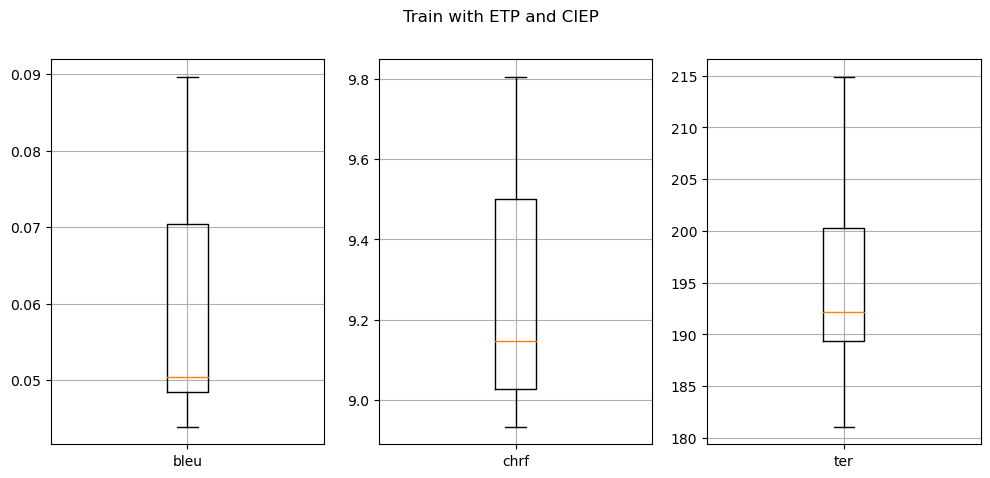

In [6]:
plot_results(results, "Train with ETP and CIEP")

## Experiment: use only ETP

In [7]:
etp_data = data[data["key"].isna()]
results, example = run_n_experiments(etp_data)

with open("Results/random_etp.json", "w") as f:
    json.dump(results, f, indent=4)

print_stats(results)

100%|██████████| 10/10 [00:00<00:00, 16.28it/s]

Mean:
bleu      0.323929
chrf     13.969656
ter     133.878149
dtype: float64
Standar deviation:
bleu     0.064458
chrf     1.149744
ter     11.876846
dtype: float64


In [8]:
print_example(example)

------------------------------------------------------------
Etruscan:  eca : σ'uθic : velus : ezpus | clensi : cerine 
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: from wife and sani the of victim ceisui
------------------------------------------------------------


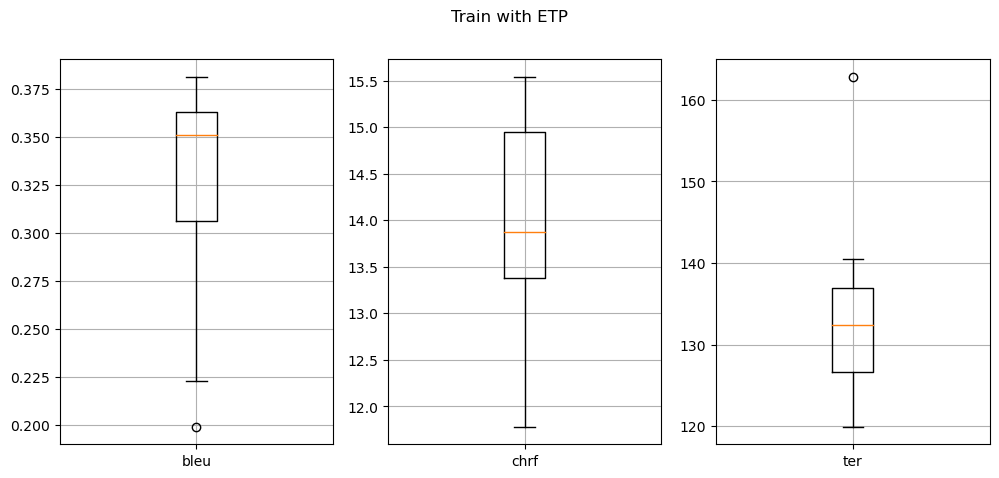

In [9]:
plot_results(results, "Train with ETP")

## Experiment: use only CIEP

In [10]:
ciep_data = data.dropna(subset=["key"])
results, example = run_n_experiments(ciep_data)

with open("Results/random_ciep.json", "w") as f:
    json.dump(results, f, indent=4)

print_stats(results)

100%|██████████| 10/10 [00:03<00:00,  3.22it/s]

Mean:
bleu      0.068534
chrf      8.859145
ter     197.032895
dtype: float64
Standar deviation:
bleu    0.013926
chrf    0.515749
ter     8.040063
dtype: float64


In [11]:
print_example(example)

------------------------------------------------------------
Etruscan: --itenurziu
Reference: titenurizu
Prediction: evas -- twoasin -- -- -- creste jupitersin vennona
------------------------------------------------------------


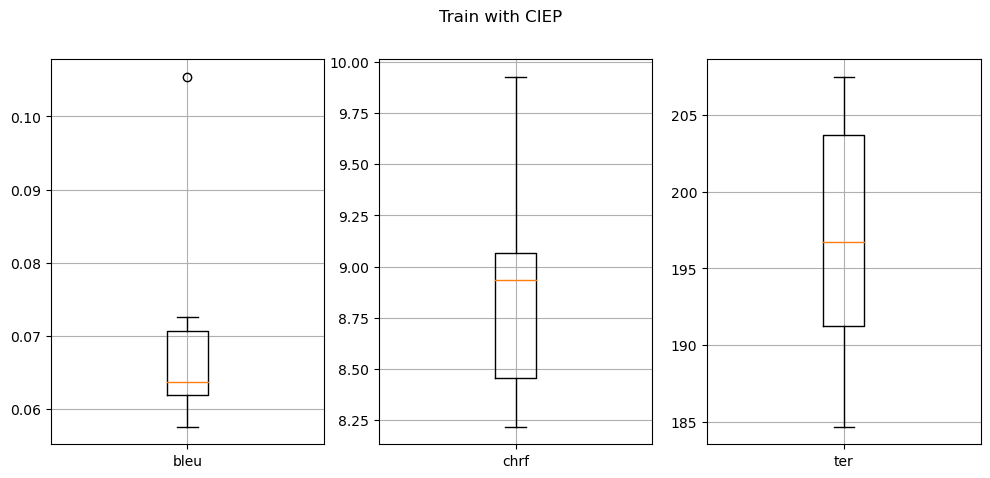

In [12]:
plot_results(results, "Train with CIEP")

## Experiment: train on CIEP, test on ETP

In [13]:
results = defaultdict(list)
rng = np.random.RandomState(0)
n = 10
for _ in tqdm(range(n), total=n):
    train, _ = random_split(ciep_data, 1, rng)
    test, _ = random_split(etp_data, 1, rng)
    train = make_set(train)
    test = make_set(test)
    train = (train[0], [clean(i) for i in train[1]])
    test = (test[0], [clean(i) for i in test[1]])
    tmp_res, example = run_experiment(train, test, rng.randint(1000))
    for i, j in tmp_res.items():
        results[i].append(j)

with open("Results/random_train_ciep_test_etp.json", "w") as f:
    json.dump(results, f, indent=4)

print_stats(results)

100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

Mean:
bleu      0.028609
chrf      8.926438
ter     102.295212
dtype: float64
Standar deviation:
bleu    0.006873
chrf    0.345720
ter     0.401835
dtype: float64


In [14]:
print_example(example)

------------------------------------------------------------
Etruscan:  vel : aties : velθurus : lemniσ'a : celati cesu 
Reference: vel aties the son of velthur and lemni was buried in this chamber
Prediction: daughters prechus
------------------------------------------------------------


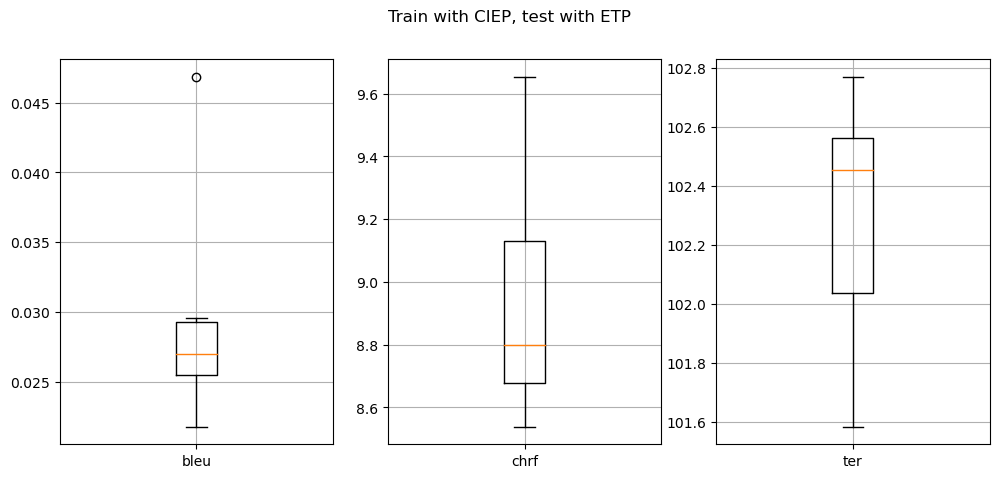

In [15]:
plot_results(results, "Train with CIEP, test with ETP")